# Amazon Fine Food Reviews Analysis


Developer : PraveenAI

Source Copyrights: Wherever I have copied any code snippets, I used it understanding it throughly. Also povided the links.
                  
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [128]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [129]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 900000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [130]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [131]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [132]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [133]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [134]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [135]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [136]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [137]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [138]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [139]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [140]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [141]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[15]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
My 7 year old daughter brought this book home from the school library. It was a little easy for her reading skills, but she loved it anyways. My 4 year old daughter started reading it and now we can't get her to return it to school. The book is small but this is better for little hands. This is a great book for any age! The pictures are cute and go well with th

In [142]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [143]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
My 7 year old daughter brought this book home from the school library. It was a little easy for her reading skills, but she loved it anyways. My 4 year old daughter started reading it and now we can't get her to return it to school. The book is small but this is better for little hands. This is a great book for any age! The pictures are cute and go well with th

In [144]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [145]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My 7 year old daughter brought this book home from the school library. It was a little easy for her reading skills, but she loved it anyways. My 4 year old daughter started reading it and now we can not get her to return it to school. The book is small but this is better for little hands. This is a great book for any age! The pictures are cute and go well with the writing. The rhyming makes it easy to get to know the months. I recommend this book to every parent!


In [146]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [147]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My 7 year old daughter brought this book home from the school library It was a little easy for her reading skills but she loved it anyways My 4 year old daughter started reading it and now we can not get her to return it to school The book is small but this is better for little hands This is a great book for any age The pictures are cute and go well with the writing The rhyming makes it easy to get to know the months I recommend this book to every parent 


In [148]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [149]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:55<00:00, 2076.34it/s]


In [150]:
preprocessed_reviews[5]

'charming rhyming book describes circumstances eat not chicken soup rice month month sounds like kind thing kids would make recess sing drive teachers crazy cute catchy sounds really childlike skillfully written'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [151]:
## Similartly you can do preprocessing for review summary also.

In [152]:
X = preprocessed_reviews
Y = final['Score']

In [153]:
from sklearn.cross_validation import train_test_split
X_1 , X_test , Y_1 , Y_test  = train_test_split(X,Y,test_size=0.3,random_state=0)
X_tr , X_cv , Y_tr , Y_cv  = train_test_split(X_1,Y_1,test_size=0.3,random_state=0)

We Split the Data for Train, Test and CrossValidation.

Train Data is to Train the Model. Wherase Cross validation is to understand the Over/Under fit of a model.

Majorly The Cross Validation will be usefull to figureout the best no of nearest neibhours, It helps the model to Test With.

Test Data is exclusively for testing the trained Model. where we prediect the Outcomes.

# [4] Featurization

## [4.1] BAG OF WORDS

In [154]:
#BoW
count_vect = CountVectorizer(min_df=50, max_features=40) #in scikit-learn  max no of feature in a vector is 300
count_vect.fit(X_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_Bow_Tr = count_vect.transform(X_tr)
X_Bow_Cv = count_vect.transform(X_cv)
X_Bow_Test = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_Bow_Tr))
print("the shape of out text BOW vectorizer ",X_Bow_Tr.get_shape())
print("the number of unique words ", X_Bow_Tr.get_shape()[1])

some feature names  ['also', 'amazon', 'best', 'better', 'buy', 'chocolate', 'coffee', 'could', 'eat', 'even']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (178443, 40)
the number of unique words  40


In [155]:
Bow_Feature = count_vect.get_feature_names()

In [156]:
X_Bow_Tr = X_Bow_Tr.toarray()
X_Bow_Cv = X_Bow_Cv.toarray()
X_Bow_Test = X_Bow_Test.toarray()

We got the Bag of words vector for each review

Each vectore is of 100 Dimensions.

We have Converted the Train data, Cross Validation Data and the Test to an Identical form, that is Bag Of Words

Also converted the sparse matrixes to dense matrixes

## [4.3] TF-IDF

In [157]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=50, max_features=20)
tf_idf_vect.fit(X_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


X_Tfidf_Tr = tf_idf_vect.transform(X_tr)
X_Tfidf_Cv = tf_idf_vect.transform(X_cv)
X_Tfidf_Test = tf_idf_vect.transform(X_test)

print("the type of count vectorizer ",type(X_Tfidf_Tr))
print("the shape of out text TFIDF vectorizer ",X_Tfidf_Tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_Tfidf_Tr.get_shape()[1])

some sample features(unique words in the corpus) ['amazon', 'coffee', 'flavor', 'food', 'get', 'good', 'great', 'like', 'love', 'much']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (178443, 20)
the number of unique words including both unigrams and bigrams  20


In [158]:
X_Tfidf_Tr = X_Tfidf_Tr.toarray()
X_Tfidf_Cv = X_Tfidf_Cv.toarray()
X_Tfidf_Test = X_Tfidf_Test.toarray()

In [159]:
X_Tfidf_Tr[0]

array([0.        , 0.        , 0.58249888, 0.        , 0.        ,
       0.        , 0.        , 0.23925546, 0.        , 0.64949614,
       0.        , 0.17305432, 0.27047058, 0.28018657, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

We got the TfIdf s vector for each review

Each vectore is of 100 Dimensions.

We have Converted the Train data, Cross Validation Data and the Test to an Identical form, that is TfIdf-vector

Also converted the sparse matrixes to dense matrixes

# [5]  Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [160]:
# Please write all the code with proper documentation

Naive Bayes is Model is for Binary Dataset where the feature values are with 0 or 1.

Here in out Dataset for both Bag Of Words of Tf-Idf, Feature values are the conintues Real values.

Mullitinomial Naive Bayes is type of Naive Bayes Algorithm which is available in Scikit.

This is will helps to work out the Naive Bayes on top of Multivalued feuaters (not only binary)

Hence we have selected the MultinomialNB.

In [161]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,roc_auc_score

For Naive Bayes Alogorithm will calculate the likelyhoods and priors of each features 

And As per the, Theorem To find the probability of class Given the N-Dimensions,

we will calculate the summation of fueature (product of Likehood ly and priors)

To Avoid zero mulitplication problem which will probes the entire prediction wrongly we will aplly the concept called Additive Smooting.


We will find the best Over Alpha for not getting Over/Under fitting.



In [162]:
Alpha = np.arange(-5,10,1)
Alpha = np.array(10.0**Alpha) 
print(Alpha)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09]


In [163]:
Set1_Acc_Tr    = []
Set1_Acc_Cv    = []
Set1_Train_Auc = []
Set1_Cv_Auc    = []    
Set1_Coef_Tr   = []
Set1_Coef_Cv   = []
Imp_Features   = []

for i in Alpha:
    clf = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    clf.fit(X_Bow_Tr, Y_tr)    
    
    
    #CO-Efficeints
    Co_Eff = clf.coef_[0].tolist()
    Co_Eff_Sorted = sorted(Co_Eff)  
    Co_Eff_Sorted.reverse()    

    pred_tr =  clf.predict(X_Bow_Tr) # Class-Predictions of TRAIN-Validation
    pred_cv =  clf.predict(X_Bow_Cv) # Class-Predictions of Cross-Validation

    train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation
             
    Train_pred_prob =  clf.predict_proba(X_Bow_Tr)[:,1]    # Probablity of TRAIN-Validation
    Cv_pred_prob    =  clf.predict_proba(X_Bow_Cv)[:,1]    # Probablity of Cross-Validation         
    cv_auc          = roc_auc_score(Y_cv, Cv_pred_prob)
    train_auc       = roc_auc_score(Y_tr, Train_pred_prob)
        
    Set1_Acc_Tr.append(train_acc)                #Accuracy                
    Set1_Acc_Cv.append(cv_acc)                   #Accuracy   
    Set1_Train_Auc.append(train_auc)             #AUc
    Set1_Cv_Auc.append(cv_auc)                   #AUc
    #Imp_Features.append(local_Imp_Features)    #AUc  
    
    print(" AUC for the  TRAIN Data at alpha of Laplace Smoothing ",i,  " is ", train_auc)
    print(" AUC for the Cross-Validation Data at  alpha of Laplace Smoothing  ",i,  " is ", cv_auc)

 AUC for the  TRAIN Data at alpha of Laplace Smoothing  1e-05  is  0.7758102829487484
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   1e-05  is  0.7725487833324738
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  0.0001  is  0.775810282473753
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   0.0001  is  0.7725487846373678
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  0.001  is  0.7758102831862462
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   0.001  is  0.7725487794177918
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  0.01  is  0.7758102549240202
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   0.01  is  0.772548735051395
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  0.1  is  0.7758099072273905
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   0.1  is  0.7725481178365232
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  1.0  is  0.7758082768056948
 A

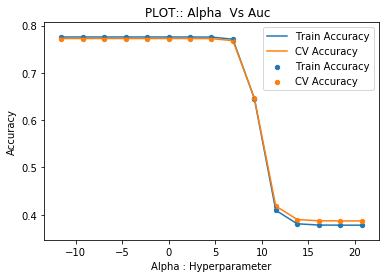

In [164]:
#plt.grid()
plt.scatter(np.log(Alpha), Set1_Train_Auc, label='Train Accuracy',s=19)    
plt.plot(np.log(Alpha), Set1_Train_Auc, label='Train Accuracy')
plt.scatter(np.log(Alpha), Set1_Cv_Auc, label='CV Accuracy',s=19)
plt.plot(np.log(Alpha), Set1_Cv_Auc, label='CV Accuracy')
#plt.plot(X, , c = '.75', lw = 2., label = r'$f(x)=\log(x)$'
#plt.xscale('log') 
plt.legend()
plt.xlabel("Alpha : Hyperparameter")
plt.ylabel("Accuracy")
plt.title("PLOT:: Alpha  Vs Auc  ")
plt.show()

In [165]:
Optimal_Alpha = Alpha[Set1_Cv_Auc.index(max(Set1_Cv_Auc))]
print("Highest AUC for CrosValidation, Laplace Smoothing is at : ", Optimal_Alpha )
Optimal_Alpha1 = Optimal_Alpha

Highest AUC for CrosValidation, Laplace Smoothing is at :  0.0001


Our Optimal Alpha (Addtive smoothing value)  for BagOfWords Dataset is 1e-05. 

Lets try out to train the Model with Optimal Alpha and Evalute the model with our testin Data. 

As AUC is One of the best Metrics to weigh a model we are focusing much on it.

In [166]:
clf = MultinomialNB(alpha=Optimal_Alpha, class_prior=None, fit_prior=True)
clf.fit(X_Bow_Tr, Y_tr)  

Set1_Tr_Pred =  clf.predict(X_Bow_Tr)
Set1_Tr_pred_prob =  clf.predict_proba(X_Bow_Tr)[:,1]
Set1_Tr_Acc  =  accuracy_score(Y_tr,Set1_Tr_Pred,normalize=True)
Set1_Tr_Auc  =  roc_auc_score(Y_tr,Train_pred_prob)

Set1_Tst_Pred     =  clf.predict(X_Bow_Test)
Set1_Tst_pred_prob =  clf.predict_proba(X_Bow_Test)[:,1]
Set1_Tst_Acc  =  accuracy_score(Y_test,Set1_Tst_Pred,normalize=True)
Set1_Tst_Auc  =  roc_auc_score(Y_test,Set1_Tst_pred_prob)

print(" Accuracy,AUC, for Train Data for the Best Laplace Smoothing : ", Set1_Tr_Acc,"  ",Set1_Tr_Auc)
print(" Accuracy,AUC, for Test Data for the Best Laplace Smoothing  : ", Set1_Tst_Acc,"  ",Set1_Tst_Auc)

 Accuracy,AUC, for Train Data for the Best Laplace Smoothing :  0.8419439260716307    0.37802209912753487
 Accuracy,AUC, for Test Data for the Best Laplace Smoothing  :  0.8400120821586791    0.7738939901891412


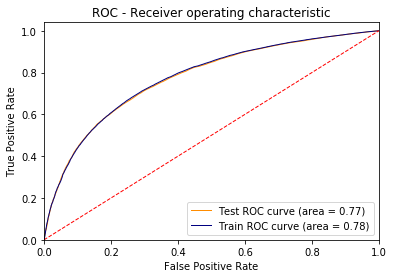

In [167]:
set1_tst_fpr, set1_tst_tpr, thresholds = roc_curve(Y_test,Set1_Tst_pred_prob)
set1_tst_roc_auc = auc(set1_tst_fpr, set1_tst_tpr)


set1_train_fpr, set1_train_tpr, thresholds = roc_curve(Y_tr,Set1_Tr_pred_prob)
set1_train_roc_auc = auc(set1_train_fpr, set1_train_tpr)

lw=1
plt.figure()
plt.plot(set1_tst_fpr, set1_tst_tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set1_tst_roc_auc)
plt.plot(set1_train_fpr, set1_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set1_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We have a Reasonable Aure under the Curve.

We have to notice that AUC for our Train Data is almost equalent to he Test Data.


###### Confusion Matrix Train Data

Train Confusion Matrix::

        Predicted
 True   [ 5014 22971]
       [  5233 145225] 



Text(33,0.5,'True label')

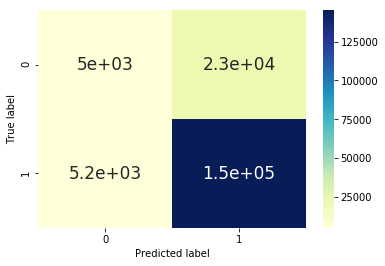

In [168]:
Train_CM= confusion_matrix(Y_tr, Set1_Tr_Pred,  sample_weight=None) 
print("Train Confusion Matrix::\n\n        Predicted\n","True  ",Train_CM[0])
print("      ",Train_CM[1],"\n",)
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')


###### Confusion Matrix for Test Data

Test Confusion Matrix::

        Predicted
 True   [ 3139 14126]
       [ 3353 88634] 



Text(33,0.5,'True label')

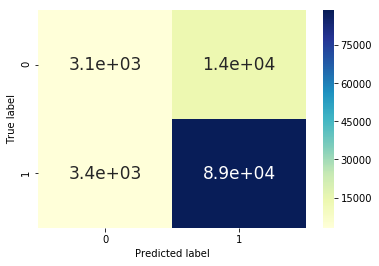

In [169]:
Test_CM= confusion_matrix(Y_test, Set1_Tst_Pred , labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n\n        Predicted\n","True  ",Test_CM[0])
print("      ",Test_CM[1],"\n",)
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .

Horizantal Lines are Predictions and the Verticals are Acutuals

Thus in binary classification, the count of true 

negatives is 154 at C(0,0) , 

false negatives is 148 C(1,0),

true positives is 11433 at C(1,1),

false positives is 2086 at C(0,1).


In [170]:
_, coef_ = clf.feature_log_prob_

In [171]:
#CO-Efficeints
Co_Eff = coef_.tolist()

In [172]:
#https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
Set1_Feat_per_change = dict(zip(Bow_Feature, Co_Eff))
#Feat_per_change = dict(enumerate(Perc))
#Feat_per_change = dict(zip(key, values))

In [173]:
#https://www.saltycrane.com/blog/2007/09/how-to-sort-python-dictionary-by-keys/
set1_Pstv_Co_Effs = {k:v for (k,v) in Set1_Feat_per_change.items() if v>0 }
set1_Neg_Co_Effs  = {k:-1*v for (k,v) in Set1_Feat_per_change.items() if v<=0 }

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [174]:
# Please write all the code with proper documentation

Text(0,0.5,'Collinearity')

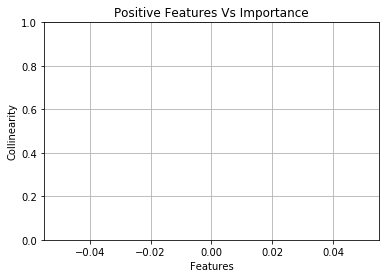

In [175]:
y = list(set1_Pstv_Co_Effs.values())
x = np.arange(0,len(set1_Pstv_Co_Effs))
Set1_pos_w_sort = sorted(y)[::-1]
plt.grid()
plt.plot(x, Set1_pos_w_sort,scaley=False,linewidth=5)
plt.title("Positive Features Vs Importance")
plt.xlabel("Features")
plt.ylabel("Collinearity")

Observation : No Positive features Available to plot 

In [176]:
Set1_Sorted_Pos_Co_Effs = sorted(set1_Pstv_Co_Effs.items(), key=lambda x: x[1])[::-1]  # 1>x[1] value, x[0] key
print("Top 10 Negative Colineal Features :: ")
print("="*30)

if len(Set1_Sorted_Pos_Co_Effs) > 0:
    for i in range(len(Set1_Sorted_Pos_Co_Effs)):  
        if(i<10):
            print("\t\tFeature :",Set1_Sorted_Pos_Co_Effs[i][0])
else:
    print("\n\t*****\tNo Features are Positively Impacting\t*****")

Top 10 Negative Colineal Features :: 

	*****	No Features are Positively Impacting	*****


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [177]:
# Please write all the code with proper documentation

Text(0,0.5,'Collinearity')

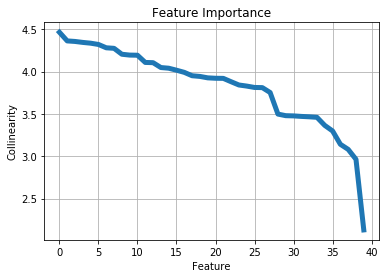

In [178]:
y = list(set1_Neg_Co_Effs.values())
Set2_Neg_w_sort = sorted(y)[::-1]
x = np.arange(0,len(set1_Neg_Co_Effs))
plt.grid()
plt.plot(x, Set2_Neg_w_sort,linewidth=5)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Collinearity")

Above are the Important Features wih Negative C0-Effecients in sorted Order

In [179]:
Set1_Sorted_Neg_Co_Effs = sorted(set1_Neg_Co_Effs.items(), key=lambda x: x[1])[::-1]  # 1>x[1] value, x[0] key
print("Top 10 Negative Colineal Features :: ")
print("="*30)

if len(Set1_Sorted_Neg_Co_Effs) > 0:
    for i in range(len(Set1_Sorted_Neg_Co_Effs)):  
        if(i<10):
            print("\t\tFeature :",Set1_Sorted_Neg_Co_Effs[i][0])
else:
    print("\n\t\tNo Features are Positively Impacting")

Top 10 Negative Colineal Features :: 
		Feature : could
		Feature : first
		Feature : water
		Feature : found
		Feature : used
		Feature : sugar
		Feature : eat
		Feature : chocolate
		Feature : better
		Feature : even


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [180]:
Set2_Acc_Tr    = []
Set2_Acc_Cv    = []
Set2_Train_Auc = []
Set2_Cv_Auc    = []    


for i in Alpha:
    clf = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    clf.fit(X_Tfidf_Tr, Y_tr)    
    
    #CO-Efficeints
    Co_Eff = clf.coef_[0].tolist()
    Co_Eff_Sorted = sorted(Co_Eff)  
    Co_Eff_Sorted.reverse()    

    pred_tr =  clf.predict(X_Tfidf_Tr) # Class-Predictions of TRAIN-Validation
    pred_cv =  clf.predict(X_Tfidf_Cv) # Class-Predictions of Cross-Validation

    train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation
             
    Train_pred_prob =  clf.predict_proba(X_Tfidf_Tr)[:,1]    # Probablity of TRAIN-Validation
    Cv_pred_prob    =  clf.predict_proba(X_Tfidf_Cv)[:,1]    # Probablity of Cross-Validation         
    cv_auc    = roc_auc_score(Y_cv, Cv_pred_prob)
    train_auc   = roc_auc_score(Y_tr, Train_pred_prob)
    
    Set2_Acc_Tr.append(train_acc)                #Accuracy                
    Set2_Acc_Cv.append(cv_acc)                   #Accuracy   
    Set2_Train_Auc.append(train_auc)             #AUc
    Set2_Cv_Auc.append(cv_auc)                   #AUc
    #Imp_Features.append(local_Imp_Features)  #AUc
  
    
    print(" AUC for the  TRAIN Data at alpha of Laplace Smoothing ",i,  " is ", train_auc)
    print(" AUC for the Cross-Validation Data at  alpha of Laplace Smoothing  ",i,  " is ", cv_auc)

 AUC for the  TRAIN Data at alpha of Laplace Smoothing  1e-05  is  0.7422122256960668
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   1e-05  is  0.7413505171608178
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  0.0001  is  0.742212217739894
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   0.0001  is  0.741350528252417
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  0.001  is  0.7422121366344301
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   0.001  is  0.7413505132461358
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  0.01  is  0.7422121982650827
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   0.01  is  0.7413505673992377
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  0.1  is  0.7422121914963983
 AUC for the Cross-Validation Data at  alpha of Laplace Smoothing   0.1  is  0.7413503175120328
 AUC for the  TRAIN Data at alpha of Laplace Smoothing  1.0  is  0.7422332931668518
 A

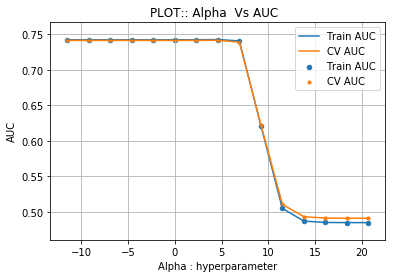

In [181]:
plt.grid()
plt.scatter(np.log(Alpha), Set2_Train_Auc, label='Train AUC',s=20)
plt.plot(np.log(Alpha), Set2_Train_Auc, label='Train AUC')
plt.scatter(np.log(Alpha), Set2_Cv_Auc, label='CV AUC',s=10)
plt.plot(np.log(Alpha), Set2_Cv_Auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("PLOT:: Alpha  Vs AUC  ")
plt.show()

In [182]:
Optimal_Alpha = Alpha[Set2_Cv_Auc.index(max(Set2_Cv_Auc))]
print("Highest AUC is at Alpha: ", Optimal_Alpha )
print(Set2_Cv_Auc)
print(max(Set2_Cv_Auc))
Optimal_Alpha2 = Optimal_Alpha

Highest AUC is at Alpha:  100.0
[0.7413505171608178, 0.741350528252417, 0.7413505132461358, 0.7413505673992377, 0.7413503175120328, 0.7413509712639371, 0.7413711416632617, 0.7415343532402399, 0.7388559101573159, 0.6226505898590736, 0.5102246478143234, 0.4929189932492092, 0.49095596614248904, 0.4907593975596603, 0.4907337805326932]
0.7415343532402399


In [183]:
Set2_Train_Auc = Set2_Train_Auc[Set2_Cv_Auc.index(max(Set2_Cv_Auc))]
print(" Set2 Highest AUC is  : ", Set2_Train_Auc )

 Set2 Highest AUC is  :  0.7425736614487845


Our Optimal Alpha (Addtive smoothing value) for BagOfWords Dataset is 100.

Lets try out to train the Model with Optimal Alpha and Evalute the model with our testin Data.

As AUC is One of the best Metrics to weigh a model we are focusing much on it.

In [184]:
clf = MultinomialNB(alpha=Optimal_Alpha, class_prior=None, fit_prior=True)
clf.fit(X_Tfidf_Tr, Y_tr)  

Set2_Tr_Pred =  clf.predict(X_Tfidf_Tr)
Set2_Tr_pred_prob =  clf.predict_proba(X_Tfidf_Tr)[:,1]
Set2_Tr_Acc  =  accuracy_score(Y_tr,Set2_Tr_Pred,normalize=True)
Set2_Tr_Auc  =  roc_auc_score(Y_tr,Train_pred_prob)


Set2_Tst_Pred     =  clf.predict(X_Tfidf_Test)
Set2_Tst_pred_prob =  clf.predict_proba(X_Tfidf_Test)[:,1]
Set2_Tst_Acc  =  accuracy_score(Y_test,Set2_Tst_Pred,normalize=True)
Set2_Tst_Auc  =  roc_auc_score(Y_test,Set2_Tst_pred_prob)

print(" AUC,  for Train Data for the Optimal Alpha : ", Set2_Tr_Auc)
print(" AUC,  for Test Data for the Optimal Alpha  : ", Set2_Tst_Auc)

 AUC,  for Train Data for the Optimal Alpha :  0.48457142232998907
 AUC,  for Test Data for the Optimal Alpha  :  0.7406419640675563


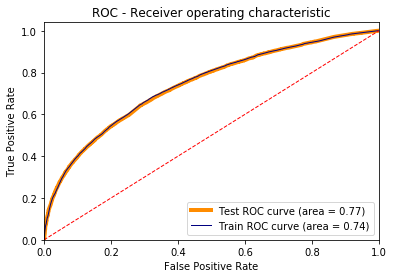

In [185]:
set2_tst_fpr, set2_tst_tpr, thresholds = roc_curve(Y_test,Set2_Tst_pred_prob)
set2_tst_roc_auc = auc(set1_tst_fpr, set1_tst_tpr)


set2_train_fpr, set2_train_tpr, thresholds = roc_curve(Y_tr,Set2_Tr_pred_prob)
set2_train_roc_auc = auc(set2_train_fpr, set2_train_tpr)

lw=1
plt.figure()
plt.plot(set2_tst_fpr, set2_tst_tpr, color='darkorange', lw=4, label='Test ROC curve (area = %0.2f)' % set2_tst_roc_auc)
plt.plot(set2_train_fpr, set2_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set2_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We have a Reasonable Aure under the Curve.

We have to notice that AUC for our Train Data is almost equalent to he Test Data.


#### Confusion Matrix for Train Data

Train Confusion Matrix::

        Predicted
 True   [    0 27985]
       [     0 150458] 



Text(33,0.5,'True label')

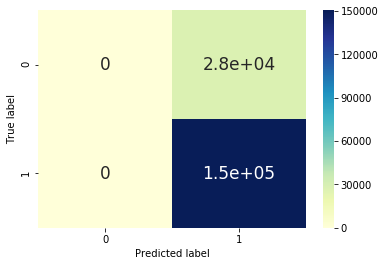

In [186]:
Train_CM= confusion_matrix(Y_tr, Set2_Tr_Pred, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n\n        Predicted\n","True  ",Train_CM[0])
print("      ",Train_CM[1],"\n",)
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')

#### Confusion Matrix for Test Data

Test Confusion Matrix::

        Predicted
 True   [    0 17265]
       [    0 91987] 



Text(33,0.5,'True label')

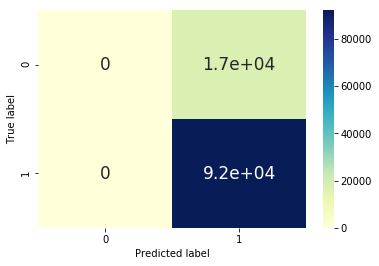

In [187]:
Test_CM= confusion_matrix(Y_test, Set2_Tst_Pred , labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n\n        Predicted\n","True  ",Test_CM[0])
print("      ",Test_CM[1],"\n",)
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .

Horizantal Lines are Predictions and the Verticals are Acutuals

Thus in binary classification, the count of true 

negatives is 0 at C(0,0) , 

false negatives is 0 C(1,0),

true positives is 91987 at C(1,1),

false positives is 17265 at C(0,1).


In [188]:
_, coef_ = clf.feature_log_prob_

In [189]:
#CO-Efficeints
Co_Eff = coef_.tolist()

In [190]:
#https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
Set2_Feat_per_change = dict(zip(Bow_Feature, Co_Eff))
#Feat_per_change = dict(enumerate(Perc))
#Feat_per_change = dict(zip(key, values))

In [191]:
#https://www.saltycrane.com/blog/2007/09/how-to-sort-python-dictionary-by-keys/
set2_Pstv_Co_Effs = {k:v for (k,v) in Set2_Feat_per_change.items() if v>0 }
set2_Neg_Co_Effs  = {k:-1*v for (k,v) in Set2_Feat_per_change.items() if v<=0 }

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [192]:
# Please write all the code with proper documentation

Text(0,0.5,'Collinearity')

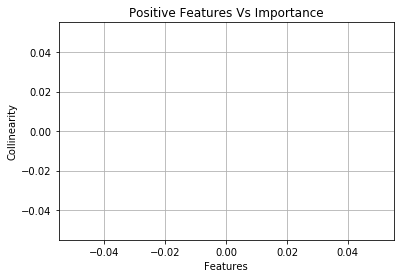

In [193]:
y = list(set2_Pstv_Co_Effs.values())
x = np.arange(0,len(set2_Pstv_Co_Effs))
Set2_pos_w_sort = sorted(y)[::-1]
plt.grid()
plt.plot(x, Set2_pos_w_sort,linewidth=5)
plt.title("Positive Features Vs Importance")
plt.xlabel("Features")
plt.ylabel("Collinearity")

There are no Positive Co-Efficients in the exists

In [194]:
Set2_Sorted_Pos_Co_Effs = sorted(set2_Pstv_Co_Effs.items(), key=lambda x: x[1])[::-1]  # 1>x[1] value, x[0] key
print("Top 10 Negative Colineal Features :: ")
print("="*30)

if len(Set2_Sorted_Pos_Co_Effs) > 0:
    for i in range(len(Set2_Sorted_Pos_Co_Effs)):  
        if(i<10):
            print("\t\tFeature :",Set2_Sorted_Pos_Co_Effs[i][0])
else:
    print("\n\t*****\tNo Features are Positively Impacting\t*****")

Top 10 Negative Colineal Features :: 

	*****	No Features are Positively Impacting	*****


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [195]:
# Please write all the code with proper documentation

Text(0,0.5,'Collinearity')

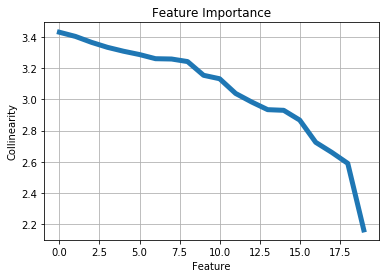

In [196]:
y = list(set2_Neg_Co_Effs.values())
Set2_Neg_w_sort = sorted(y)[::-1]
x = np.arange(0,len(set2_Neg_Co_Effs))
plt.grid()
plt.plot(x, Set2_Neg_w_sort,linewidth=5)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Collinearity")

Above are the Top 10 Highly Important Features wih Negative C0-Effecients

In [197]:
Set2_Sorted_Neg_Co_Effs = sorted(set2_Neg_Co_Effs.items(), key=lambda x: x[1])[::-1]  # 1>x[1] value, x[0] key
print("Top 10 Negative Colineal Features :: ")
print("="*30)

if len(Set2_Sorted_Neg_Co_Effs) > 0:
    for i in range(len(Set2_Sorted_Neg_Co_Effs)):  
        if(i<10):
            print("\t\tFeature :",Set2_Sorted_Neg_Co_Effs[i][0])
else:
    print("\n\t\tNo Features are Positively Impacting")

Top 10 Negative Colineal Features :: 
		Feature : better
		Feature : even
		Feature : great
		Feature : find
		Feature : found
		Feature : like
		Feature : also
		Feature : buy
		Feature : good
		Feature : amazon


### [5.3]Fueature Engineering : Adding length of each review as its new  feature<font color='red'> Updated DataSet</font>

In [198]:
# Please write all the code with proper documentation

In [199]:
len_Tr = []
for i in X_tr:
    len_Tr.append(len(i))
len_Cv = []
for i in X_cv:
    len_Cv.append(len(i))
len_Tst = []
for i in X_test:
    len_Tst.append(len(i))

In [200]:
#a = np.array([[1, 1], [2, 2], [3, 3]])
#print(np.insert(a[0], 2, 5))
#np.insert(dup[0],int,777)

lets us Recreate the Dataset with the Feature Egineering.

I have addded a new feature that is the length of a review.

We just have to to understand if this new feature will helps us in impacting the label or not.

In [201]:
def getNewFutre(old,typ):
    new = []
    for i in range(len(old)):
        if(typ=="tr"):
            e= len_Tr[i]
        if(typ=="cv"):
            e= len_Cv[i]
        if(typ=="tst"):
            e= len_Tst[i]             
        l= list(old[i])
        l.append(e)
        new.append(l)
    return(new)

In [202]:
X_Bow_Tr_new     = []
X_Bow_Cv_new     = []
X_Bow_Test_new   = []
X_Tfidf_Tr_new   = []
X_Tfidf_Test_new = []
X_Tfidf_Cv_new   = []

X_Bow_Tr_new     = getNewFutre(X_Bow_Tr,"tr")
X_Bow_Cv_new     = getNewFutre(X_Bow_Cv,"cv")
X_Bow_Test_new   = getNewFutre(X_Bow_Test,"tst")

X_Tfidf_Tr_new   = getNewFutre(X_Tfidf_Tr,"tr")
X_Tfidf_Test_new = getNewFutre(X_Tfidf_Test,"tst")
X_Tfidf_Cv_new   = getNewFutre(X_Tfidf_Cv,"cv")

In [203]:
print(len(X_tr[4]))
print(X_Bow_Test_new[4])

214
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 161]


In [204]:
Set1_Acc_Tr_ln    = []
Set1_Acc_Cv_ln    = []
Set1_Train_Auc_ln = []
Set1_Cv_Auc_ln    = []

for i in Alpha:
    clf = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    clf.fit(X_Bow_Tr_new, Y_tr)    
    
    #CO-Efficeints
    Co_Eff = clf.coef_[0].tolist()
    Co_Eff_Sorted = sorted(Co_Eff)  
    Co_Eff_Sorted.reverse()    

    pred_tr =  clf.predict(X_Bow_Tr_new) # Class-Predictions of TRAIN-Validation
    pred_cv =  clf.predict(X_Bow_Cv_new) # Class-Predictions of Cross-Validation

    train_acc  = accuracy_score(Y_tr,pred_tr,normalize=True)    # Accuracy of TRAIN-Validation
    cv_acc  = accuracy_score(Y_cv,pred_cv,normalize=True)     # Accuracy of TRAIN-Validation
             
    Train_pred_prob =  clf.predict_proba(X_Bow_Tr_new)[:,1]    # Probablity of TRAIN-Validation
    Cv_pred_prob    =  clf.predict_proba(X_Bow_Cv_new)[:,1]    # Probablity of Cross-Validation         
    cv_auc          = roc_auc_score(Y_cv, Cv_pred_prob)
    train_auc       = roc_auc_score(Y_tr, Train_pred_prob)
    
    Set1_Acc_Tr_ln.append(train_acc)                #Accuracy                
    Set1_Acc_Cv_ln.append(cv_acc)                   #Accuracy   
    Set1_Train_Auc_ln.append(train_auc)             #AUc
    Set1_Cv_Auc_ln.append(cv_auc)                   #AUc
    #Imp_Features.append(local_Imp_Features)  #AUc

    print("AUC for Train Data for the Optimal Alpha            : ",train_auc, "   at Alpha", i)
    print("AUC for CrossValidation Data for the Optimal Alpha  : ",cv_auc   , "   at Alpha", i)

AUC for Train Data for the Optimal Alpha            :  0.7753408020121033    at Alpha 1e-05
AUC for CrossValidation Data for the Optimal Alpha  :  0.7720940114550905    at Alpha 1e-05
AUC for Train Data for the Optimal Alpha            :  0.7753408003496194    at Alpha 0.0001
AUC for CrossValidation Data for the Optimal Alpha  :  0.7720940153697724    at Alpha 0.0001
AUC for Train Data for the Optimal Alpha            :  0.7753408119870067    at Alpha 0.001
AUC for CrossValidation Data for the Optimal Alpha  :  0.7720939997110443    at Alpha 0.001
AUC for Train Data for the Optimal Alpha            :  0.7753408720739241    at Alpha 0.01
AUC for CrossValidation Data for the Optimal Alpha  :  0.772094044077441    at Alpha 0.01
AUC for Train Data for the Optimal Alpha            :  0.7753413328194579    at Alpha 0.1
AUC for CrossValidation Data for the Optimal Alpha  :  0.7720942019696175    at Alpha 0.1
AUC for Train Data for the Optimal Alpha            :  0.7753444288394471    at Alpha

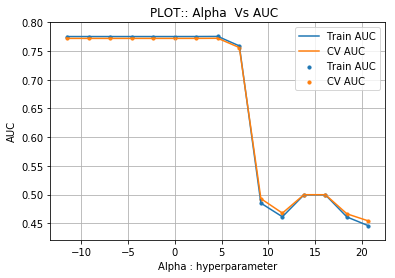

In [205]:
plt.grid()
plt.scatter(np.log(Alpha), Set1_Train_Auc_ln, label='Train AUC',s=10)
plt.plot(np.log(Alpha), Set1_Train_Auc_ln, label='Train AUC')
plt.scatter(np.log(Alpha), Set1_Cv_Auc_ln, label='CV AUC',s=10)
plt.plot(np.log(Alpha), Set1_Cv_Auc_ln, label='CV AUC')
plt.legend()
plt.xlabel("Alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("PLOT:: Alpha  Vs AUC  ")
plt.show()

In [206]:
Optimal_Alpha = Alpha[Set1_Cv_Auc_ln.index(max(Set1_Cv_Auc_ln))]
print("Highest AUC is at Alpha: ", Optimal_Alpha )
print(Set1_Cv_Auc_ln)
print(max(Set1_Cv_Auc_ln))

Optimal_Alpha3 = Optimal_Alpha

Highest AUC is at Alpha:  100.0
[0.7720940114550905, 0.7720940153697724, 0.7720939997110443, 0.772094044077441, 0.7720942019696175, 0.7720976286213158, 0.7721289095407795, 0.7722799953900705, 0.7561055247438179, 0.49287490153269725, 0.4676257124460375, 0.49972154605513835, 0.49968566473180465, 0.4663311831985604, 0.4539982259443831]
0.7722799953900705


Our Optimal Alpha (Addtive smoothing value) for BagOfWords Dataset is 100.

Lets try out to train the Model with Optimal Alpha and Evalute the model with our testin Data.

As AUC is One of the best Metrics to weigh a model we are focusing much on it.


In [207]:
clf = MultinomialNB(alpha=Optimal_Alpha, class_prior=None, fit_prior=True)
clf.fit(X_Bow_Tr_new, Y_tr)  

Set1_Tr_Pred_ln     =  clf.predict(X_Bow_Tr_new)
Set1_Tr_pred_prob_ln =  clf.predict_proba(X_Bow_Tr_new)[:,1]
Set1_Tr_Acc_ln  =  accuracy_score(Y_tr,Set1_Tr_Pred_ln,normalize=True)
Set1_Tr_Auc_ln  =  roc_auc_score(Y_tr,Set1_Tr_pred_prob_ln)


Set1_Tst_Pred_ln     =  clf.predict(X_Bow_Test_new)
Set1_Tst_pred_prob_ln =  clf.predict_proba(X_Bow_Test_new)[:,1]
Set1_Tst_Acc_ln  =  accuracy_score(Y_test,Set1_Tst_Pred,normalize=True)
Set1_Tst_Auc_ln  =  roc_auc_score(Y_test,Set1_Tst_pred_prob)

print(" Accuracy,AUC,  for New Test  Data for the Optimal Alpha  : ", Set1_Tst_Acc_ln,"  ",Set1_Tst_Auc_ln)
print(" Accuracy,AUC,  for New Train Data for the Optimal Alpha  : ", Set1_Tr_Acc_ln,"  ",Set1_Tr_Auc_ln)

 Accuracy,AUC,  for New Test  Data for the Optimal Alpha  :  0.8400120821586791    0.7738939901891412
 Accuracy,AUC,  for New Train Data for the Optimal Alpha  :  0.841730972915721    0.7755484785490168


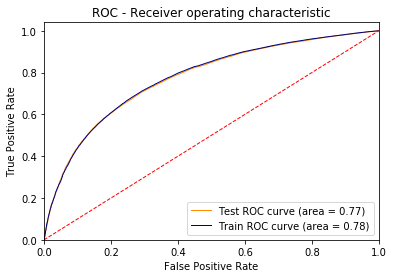

In [208]:
set1_tst_fpr_ln, set1_tst_tpr_ln, thresholds = roc_curve(Y_test,Set1_Tst_pred_prob_ln)
set1_tst_roc_auc_ln = auc(set1_tst_fpr_ln, set1_tst_tpr_ln)


set1_train_fpr_ln, set1_train_tpr_ln, thresholds = roc_curve(Y_tr,Set1_Tr_pred_prob)
set1_train_roc_auc_ln = auc(set1_train_fpr_ln, set1_train_tpr_ln)

lw=1
plt.figure()
plt.plot(set1_tst_fpr_ln, set1_tst_tpr_ln, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % set1_tst_roc_auc_ln)
plt.plot(set1_train_fpr_ln, set1_train_tpr_ln, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set1_train_roc_auc_ln)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We have a Reasonable Aure under the Curve.

We have to notice that AUC for our Train Data is almost equalent to he Test Data.


###### Confusion Matrix for Train Data

Train Confusion Matrix::

        Predicted
 True   [ 4910 23075]
       [  5167 145291] 



Text(33,0.5,'True label')

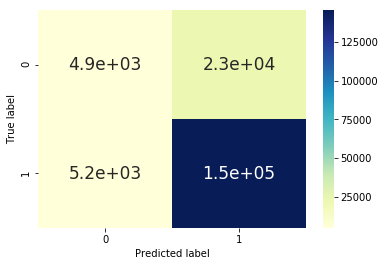

In [209]:
Train_CM= confusion_matrix(Y_tr, Set1_Tr_Pred_ln, labels=None, sample_weight=None) 
print("Train Confusion Matrix::\n\n        Predicted\n","True  ",Train_CM[0])
print("      ",Train_CM[1],"\n",)
sns.heatmap(Train_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')

#### Confusion Matrix for Test Data

Test Confusion Matrix::

        Predicted
 True   [ 3078 14187]
       [ 3315 88672] 



Text(33,0.5,'True label')

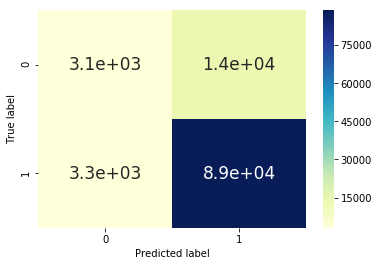

In [210]:
Test_CM= confusion_matrix(Y_test, Set1_Tst_Pred_ln , labels=None, sample_weight=None) 
print("Test Confusion Matrix::\n\n        Predicted\n","True  ",Test_CM[0])
print("      ",Test_CM[1],"\n",)
sns.heatmap(Test_CM, cmap="YlGnBu"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')


By definition a confusion matrix C is such that C-ij is equal to the number of observations known to be in group i  but predicted to be in group j .

Horizantal Lines are Predictions and the Verticals are Acutuals

Thus in binary classification, the count of true 

negatives is 3078  at C(0,0) , 

false negatives is 3315  C(1,0),

true positives is 88672 at C(1,1),

false positives is 14187 at C(0,1).


In [211]:
_, coef_ = clf.feature_log_prob_

In [212]:
Co_Eff = coef_.tolist()

In [213]:
#https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
Set1_ln_Feat_per_change = dict(zip(Bow_Feature, Co_Eff))
#Feat_per_change = dict(enumerate(Perc))
#Feat_per_change = dict(zip(key, values))

In [214]:
#https://www.saltycrane.com/blog/2007/09/how-to-sort-python-dictionary-by-keys/
set1_ln_Pstv_Co_Effs = {k:v for (k,v) in Set1_ln_Feat_per_change.items() if v>0 }
set1_ln_Negv_Co_Effs  = {k:-1*v for (k,v) in Set1_ln_Feat_per_change.items() if v<=0 }

### [5.3.1] Top 10 important features of positive class from<font color='red'> New Data Set</font>

In [215]:
if len(set1_ln_Pstv_Co_Effs):
    y = list(set1_ln_Pstv_Co_Effs.values())
    x = np.arange(0,len(y))
    Set1_ln_pos_w_sort = sorted(y)[::-1]
    plt.grid()
    plt.plot(x, Set1_ln_pos_w_sort,linewidth=5)
    plt.title("Positive Features Vs Importance")
    plt.xlabel("Features")
    plt.ylabel("Collinearity")
else:
    print("****    No features are Positively Impacting    *****")

****    No features are Positively Impacting    *****


In [216]:
Set1_ln_Sorted_Pos_Co_Effs = sorted(set1_ln_Pstv_Co_Effs.items(), key=lambda x: x[1])[::-1]  # 1>x[1] value, x[0] key
print("Top 10 Negative Colineal Features :: ")
print("="*40)

if len(Set1_Sorted_Pos_Co_Effs) > 0:
    for i in range(len(Set1_ln_Sorted_Pos_Co_Effs)):  
        if(i<10):
            print("\t\tFeature :",Set1_ln_Sorted_Pos_Co_Effs[i][0])
else:
    print("\n\t*****\tNo Features are Positively Impacting\t*****")

Top 10 Negative Colineal Features :: 

	*****	No Features are Positively Impacting	*****


### [5.3.2] Top 10 important features of Negative class from<font color='red'> New Data Set</font>

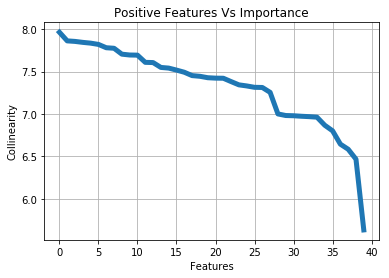

In [217]:
if len(set1_ln_Negv_Co_Effs):
    y = list(set1_ln_Negv_Co_Effs.values())
    x = np.arange(0,len(y))
    Set1_ln_pos_w_sort = sorted(y)[::-1]
    plt.grid()
    plt.plot(x, Set1_ln_pos_w_sort,linewidth=5)
    plt.title("Positive Features Vs Importance")
    plt.xlabel("Features")
    plt.ylabel("Collinearity")
else:
    print(" No features are Positie Impacting ")

In [218]:
Set1_ln_Sorted_Neg_Co_Effs = sorted(set1_ln_Negv_Co_Effs.items(), key=lambda x: x[1])[::-1]  # 1>x[1] value, x[0] key
print("Top 10 Negative Colineal Features :: ")
print("="*40)

if len(Set1_ln_Sorted_Neg_Co_Effs) > 0:
    for i in range(len(Set1_ln_Sorted_Neg_Co_Effs)):  
        if(i<10):
            print("\t\tFeature :",Set1_ln_Sorted_Neg_Co_Effs[i][0])
else:
    print("\n\t*****\tNo Features are Negative Impacting\t*****")

Top 10 Negative Colineal Features :: 
		Feature : could
		Feature : first
		Feature : water
		Feature : found
		Feature : used
		Feature : sugar
		Feature : eat
		Feature : chocolate
		Feature : better
		Feature : even


All the above Negatively Impacting feature are same as we have seen in the BagOfWords Negatively Impacting features. 

Here we should understand that the length of the review is no more impacting the result.

Hence we can try out other feature engineering Techniques to find make the difference.

### Conclusion

In [219]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["SET", "Best Hyper parameter", "Test AUC","Train AUC"]
x.add_row(["BOW",Optimal_Alpha1, Set1_Tst_Auc, Set1_Tr_Auc])
x.add_row(["Tf-Idf",Optimal_Alpha2, Set2_Tst_Auc, Set2_Tr_Auc])
x.add_row(["FeatureEngg Dataset",Optimal_Alpha3, Set1_Tst_Auc_ln, Set1_Tr_Auc_ln])
print(x)

+---------------------+----------------------+--------------------+---------------------+
|         SET         | Best Hyper parameter |      Test AUC      |      Train AUC      |
+---------------------+----------------------+--------------------+---------------------+
|         BOW         |        0.0001        | 0.7738939901891412 | 0.37802209912753487 |
|        Tf-Idf       |        100.0         | 0.7406419640675563 | 0.48457142232998907 |
| FeatureEngg Dataset |        100.0         | 0.7738939901891412 |  0.7755484785490168 |
+---------------------+----------------------+--------------------+---------------------+


TF-Idf is performing reasonbly good.

We are getting Area under the roc curve, more than 0.878.

And have to notice that, Though our Hyper Param is cahnge between Bow with feature Engineering and with out Features Engineering But AUc and the The Top Featre are same. 

